**cross-validation in time series**

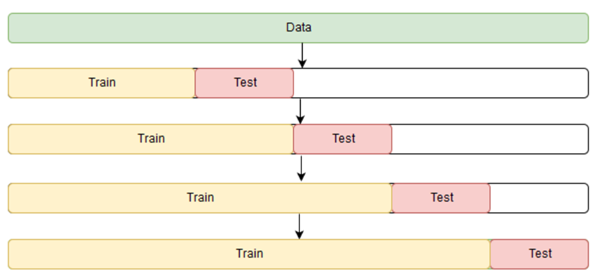

# Project description
Sweet Lift Taxi company has collected historical data on taxi orders at airports. <br>
To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. <br> 
Build a model for such a prediction. <br>
The RMSE metric on the test set should not be more than 48. <br>

# Project instructions
- Download the data and resample it by one hour.
- Analyze the data.
- Train different models with different hyperparameters. The test sample should be 10% of the initial dataset.
- Test the data using the test sample and provide a conclusion.

In [415]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose

# 1. Data preparation

## 1.1 Import data

In [416]:
# import data 
try:
    df = pd.read_csv('datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [417]:
# sort date 
df.sort_index(inplace=True)

# print min & max date
print('min date:',df.index.min())
print('max date:',df.index.max())

min date: 2018-03-01 00:00:00
max date: 2018-08-31 23:50:00


**So...** The data is for 6 months.

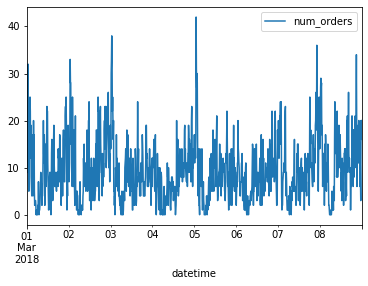

In [418]:
# plot raw data (without rescaling)
# only for 1 week
df['2018-03-01':'2018-03-08'].plot()

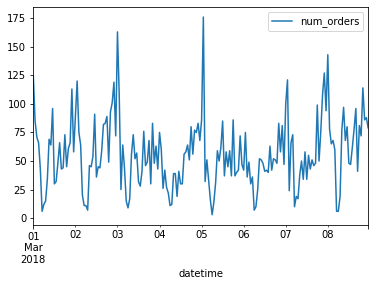

In [419]:
# rescale: find number of orders by 1 hour 
df = df.resample('1H').sum()

# plot scaled data
# only for 1 week
df['2018-03-01':'2018-03-08'].plot()

**So...** We found sum up of number of orders with the step 1 hour, so we see the same peaks.

<div class="alert alert-success">
    The data was resampled correctly!
</div>

## 1.2 analyze data

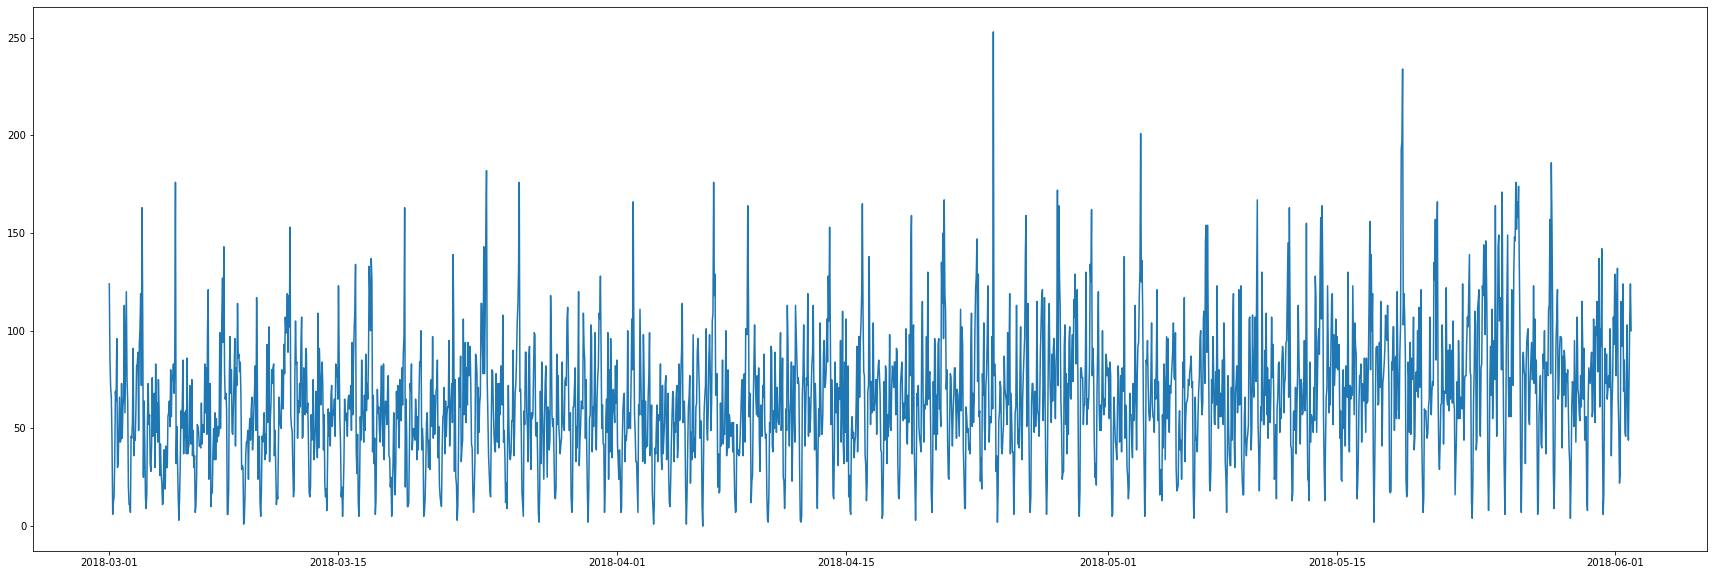

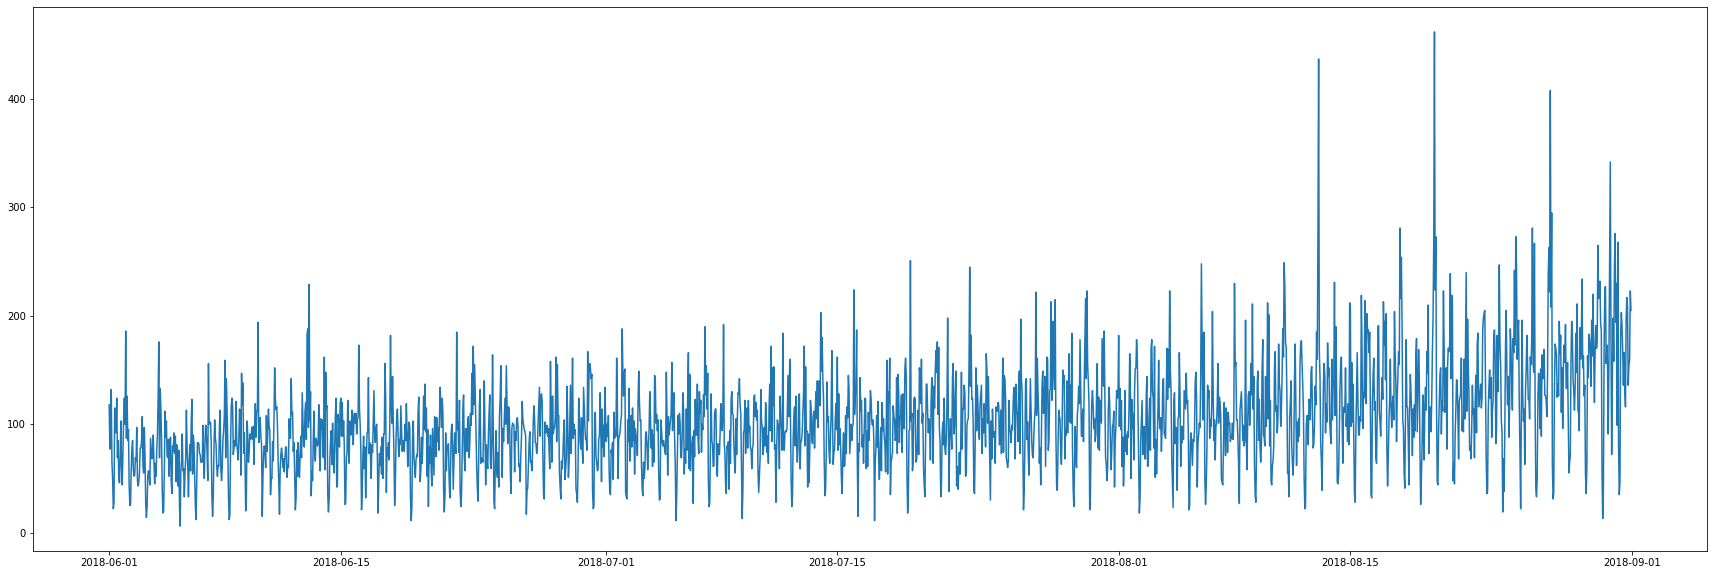

In [420]:
plt.figure(figsize=[30,10])
plt.plot(df[:'2018-06-01']['num_orders'])

plt.figure(figsize=[30,10])
plt.plot(df['2018-06-01':]['num_orders'])

**Note:** <br>
It is too dificult to analyze 1-hours step while we are considering 6-months period.

### 1.2.1 trend, seasons, fluctiation

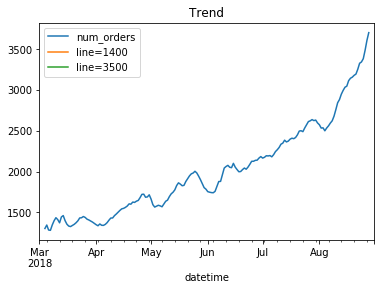

In [421]:
# note: rescaling 1-day
# Decompose a time series into trend and seasonal components

decomposed = seasonal_decompose(df.resample('1D').sum())

# trend plot
decomposed.trend.plot(ax=plt.gca())
plt.plot(df.index,[1400]*len(df), label="line=1400")
plt.plot(df.index,[3500]*len(df), label="line=3500")
plt.title('Trend')
plt.legend()

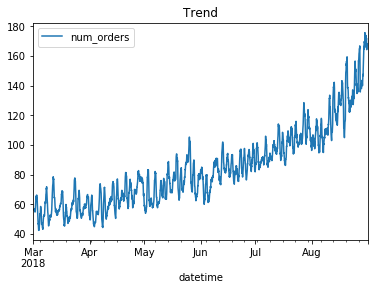

In [422]:
# note: rescaling 1-hour
decomposed = seasonal_decompose(df)

# trend plot
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.legend()

**Note:** <br>
1. Trend is increasing, so maybe <br>
(a) more likely, the number of orders grows and the business grows or <br>
(b) very unlikely, in summer and autumn number of orders increase due to increase of number of tourists, for instance. <br>
2. Trend increase much faster than linear trend (from ~1400 to ~3500).

Text(0.5, 1.0, 'Seasonality')

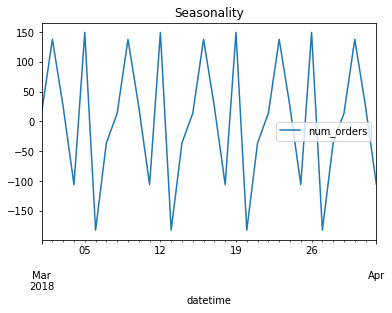

In [423]:
# seasonal
# need to limit axis (1 month)
# resample: 1 day

decomposed = seasonal_decompose(df.resample('1D').sum())
decomposed.seasonal.plot()
plt.xlim(['2018-03-01','2018-04-01'])
plt.title('Seasonality')

Text(0.5, 1.0, 'Seasonality')

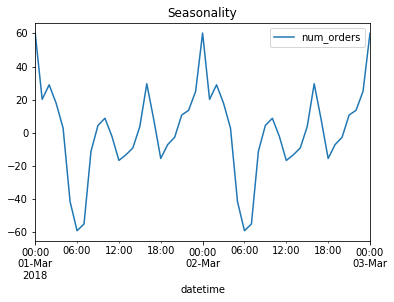

In [424]:
# resample: 1 hour

decomposed = seasonal_decompose(df)
decomposed.seasonal.plot()
plt.xlim(['2018-03-01','2018-03-03'])
plt.title('Seasonality')

Text(0.5, 1.0, 'Seasonality')

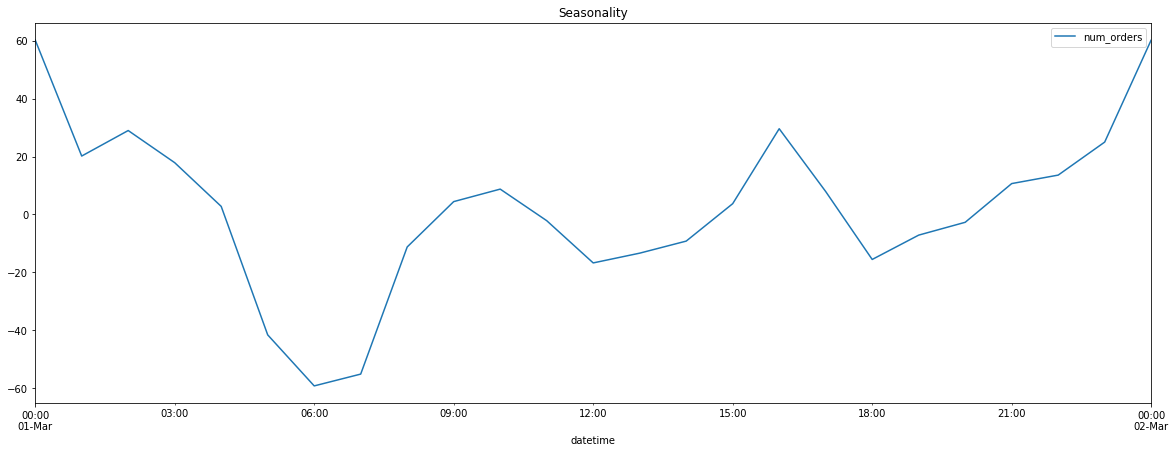

In [425]:
# resample: 1 hour

decomposed = seasonal_decompose(df)
decomposed.seasonal.plot(figsize=[20,7])
plt.xlim(['2018-03-01 00:00','2018-03-02  00:00'])
plt.title('Seasonality')

**Note:** <br>
1. We can see how change amplitude -150 to 150 and period is a week (7 days) <br>
2. In the scale of 1-hour there is a period 1 day.

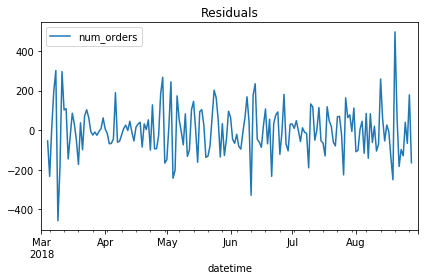

In [426]:
# residuals
decomposed = seasonal_decompose(df.resample('1D').sum())
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

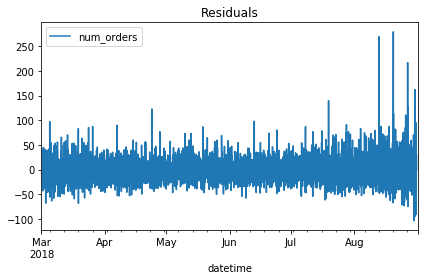

In [427]:
# residuals
decomposed = seasonal_decompose(df)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

### 1.2.2 check stationarity

In [428]:
# check sationarity
# plot mean and std in rolling

df_stats = df.resample('1D').sum().copy()
df_stats['mean'] = df_stats['num_orders'].rolling(10).mean()
df_stats['std'] = df_stats['num_orders'].rolling(10).std()

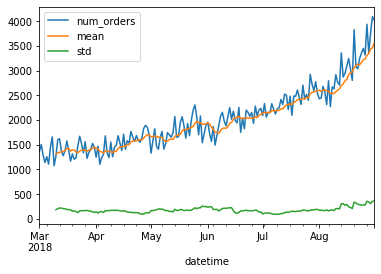

In [429]:
df_stats.plot() 

**So...** Data (time series) is not stationary, cause it's mean increase

**Results:**
1. Data has been imported.
2. Data has been analyzed. It is time series. Trend increases rapidly from 1400 to 3500, season period is 7 days. Data is not stationar.

## 1.3 should we clean outliers?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbd1f75a350>]],
      dtype=object)

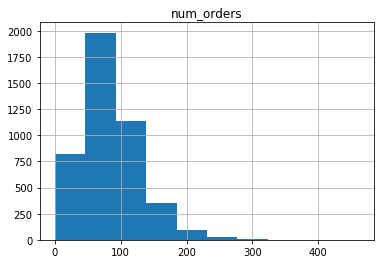

In [430]:
# plot histogram
df.hist()

In [431]:
print('Average number of orders: {:.1f}'.format(df['num_orders'].mean()))
print('Standard deviation number of orders: {:.1f}'.format(df['num_orders'].std()))
print('Maximal number of orders: {:.1f}'.format(df['num_orders'].max()))

Average number of orders: 84.4
Standard deviation number of orders: 45.0
Maximal number of orders: 462.0


**So...** There are outliers, cause max >> mju + 2 * sigma; max ~ mju + 8 * sigma; 

In [432]:
# we can use later criteria 3-sigma to train the model
print('Number of outliers with criteria 3-sigma: {:}'.format(
                        df[ df['num_orders'] > df['num_orders'].mean() + 3.*df['num_orders'].std()].shape[0] ))

Number of outliers with criteria 3-sigma: 49


# 2. Forecasting

## 2.1 Sanity forecast

In [433]:
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [434]:
# prediction: median value
train, test = train_test_split(df, shuffle=False, test_size=0.1)

pred_median = np.array([1]*len(test))*train['num_orders'].median()
rmse = mean_squared_error(test['num_orders'], pred_median) ** 0.5
print('RMSE for median prediction model: {:.1f}'.format(rmse))

RMSE for median prediction model: 87.2


In [435]:
# prediction: previous value xt(xt_1)
pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]

rmse = mean_squared_error(test['num_orders'], pred_previous) ** 0.5
print('RMSE for previous value model: {:.1f}'.format(rmse))

RMSE for previous value model: 58.9


**So...:**
The results of sanity check prediction: <br>
RMSE for median prediction model: 87.2 <br>
RMSE for previous value model: 58.9 <br>

## 2.2 ML prediction

## 2.2.1 create features

Text(0.5, 1.0, 'Seasonality')

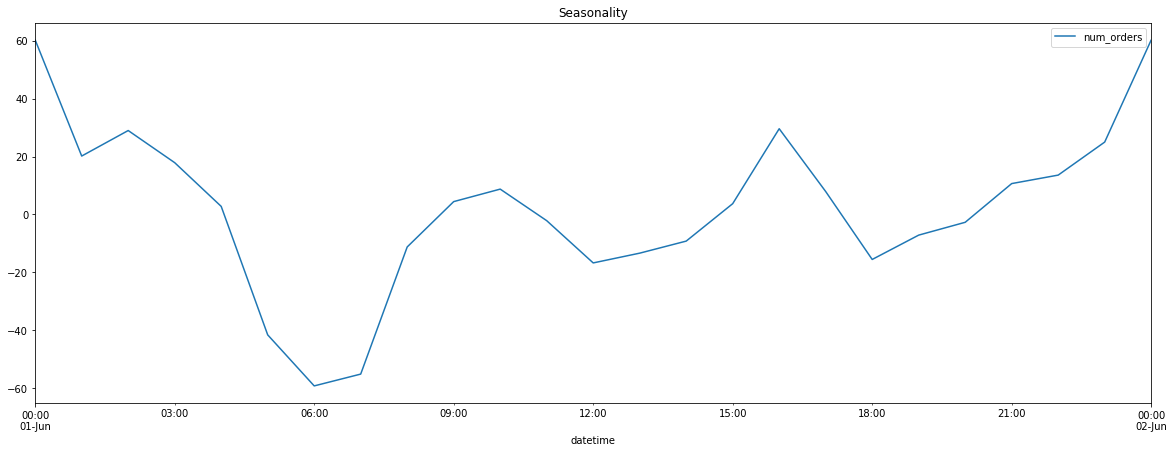

In [436]:
# resample: 1 hour

decomposed = seasonal_decompose(df)
decomposed.seasonal.plot(figsize=[20,7])
plt.xlim(['2018-06-01 00:00','2018-06-02  00:00'])
plt.title('Seasonality')

In [437]:
# create features
def make_features(table, column_name, max_lag, rolling_mean_size):
    new_table = table.copy()    
    new_table['year'] = new_table.index.year
    new_table['month'] = new_table.index.month
    new_table['day'] = new_table.index.day
    new_table['hour'] = new_table.index.hour
    new_table['dayofweek'] = new_table.index.dayofweek
    
    new_table['low_season'] = [int(5<=x<=7) for x in new_table.index.hour]
    new_table['high_season'] = [int(x==16 or x>=23 or x<=3) for x in new_table.index.hour]

    for lag in range(1, max_lag + 1):
        new_table['lag_{}'.format(lag)] = new_table[column_name].shift(lag)

    new_table['rolling_mean'] = new_table[column_name].shift().rolling(rolling_mean_size).mean()
    return new_table
    

In [438]:
# exmaple of features creating

# create new features
df_new = make_features(df, 'num_orders', 7, 12)

#drop N/A values
df_new = df_new.dropna()

In [439]:
df_new.head()

,num_orders,year,month,day,hour,dayofweek,low_season,high_season,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean
datetime,,,,,,,,,,,,,,,,
2018-03-01 12:00:00,30,2018,3,1,12,3,0,0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,57.083333
2018-03-01 13:00:00,32,2018,3,1,13,3,0,0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,49.250000
2018-03-01 14:00:00,48,2018,3,1,14,3,0,0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,44.833333
2018-03-01 15:00:00,66,2018,3,1,15,3,0,0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,42.916667
2018-03-01 16:00:00,43,2018,3,1,16,3,0,1,66.0,48.0,32.0,30.0,96.0,64.0,69.0,42.916667


## 2.2.1 linear model

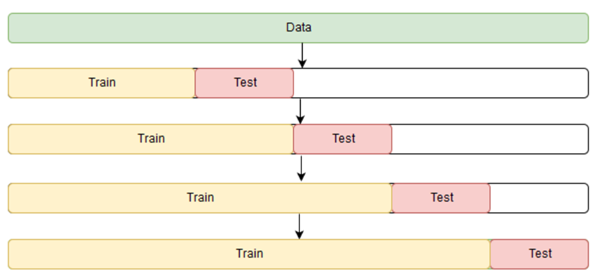

In [440]:
# split train+valid datasets and test dataset
df_train_valid, df_test = train_test_split(df, shuffle=False, test_size=0.1)

In [441]:
def lr_cross_validation_time_series(df_train_valid, valid_size, num_blocks,
                                max_lag, rolling_mean_size, num_digits):
    
    #save result to list
    rmse_valid_list = []
    # from the biggest to the smallest
    size_cut_valid = 0 # how much to cut from the end
    for k_block in range(num_blocks):
        
        # split data on train and validation datasets 
        length_df = df_train_valid.shape[0]
        df_train, df_valid = train_test_split(df_train_valid[:(length_df - size_cut_valid)],
                                              shuffle=False,
                                              test_size=valid_size)
        
        # make features and dropna
        df_train_features = make_features(df_train, 'num_orders', max_lag, rolling_mean_size)
        df_valid_features = make_features(df_valid, 'num_orders', max_lag, rolling_mean_size)
        df_train_features = df_train_features.dropna()
        df_valid_features = df_valid_features.dropna()
        
        # determine features and targets
        name_features = df_train_features.columns.drop(['num_orders'])
        features_train = df_train_features[name_features]
        target_train = df_train_features['num_orders']

        features_valid = df_valid_features[name_features]
        target_valid = df_valid_features['num_orders']
        
        # training
        lr = LinearRegression()
        lr.fit(features_train, target_train)
        
        # prediction + metrics + save result
        prediction_valid = lr.predict(features_valid)
        rmse_valid = mean_squared_error (target_valid, prediction_valid) ** 0.5
        rmse_valid_list.append(rmse_valid)
        
        # each time we cut from the initial dataframe, so size of cutting increase
        size_cut_valid += df_valid.shape[0]
    
    # return mean value
    return round(sum(rmse_valid_list) / len(rmse_valid_list), num_digits)


# application example
valid_size = 0.1
num_blocks = 3
max_lag = 3
rolling_mean_size = 12
num_digits = 2
lr_cross_validation_time_series(df_train_valid, valid_size, num_blocks, max_lag,rolling_mean_size, num_digits)

29.79

In [442]:
# tune parameters: max_lag, rolling_mean_size

result_linear = []
for number_lag in range(1,100,15):
    for window_size in range(1,50,7):
        valid_size = 0.1
        num_blocks = 3
        max_lag = number_lag
        rolling_mean_size = window_size
        num_digits = 2
        
        result_cross_validation = lr_cross_validation_time_series(
            df_train_valid, valid_size, num_blocks, max_lag,rolling_mean_size, num_digits)
        result_linear.append([number_lag, window_size, result_cross_validation])

In [443]:
columns_lr_results = ['number_lag', 'window_size', 'rmse_lr_validation']
df_result_linear = pd.DataFrame(result_linear, columns=columns_lr_results).sort_values('rmse_lr_validation')

In [444]:
df_result_linear

,number_lag,window_size,rmse_lr_validation
40,76,36,27.79
41,76,43,27.80
39,76,29,27.80
38,76,22,27.80
37,76,15,27.80
36,76,8,27.80
35,76,1,27.80
42,91,1,28.09
47,91,36,28.12
48,91,43,28.14


In [466]:
best_number_lag = df_result_linear[0:1]['number_lag'].values[0]
best_window_size = df_result_linear[0:1]['window_size'].values[0]

In [467]:
# determine train dataset with the best parameters
df_train_features = make_features(df_train_valid, 'num_orders', best_number_lag, best_window_size)
df_train_features = df_train_features.dropna()
name_features = df_train_features.columns.drop(['num_orders'])
features_train = df_train_features[name_features]
target_train = df_train_features['num_orders']

In [468]:
# 
df_train_valid, df_test = train_test_split(df, shuffle=False, test_size=0.1)

# define features and target of test dataset
df_test_features = make_features(df_test, 'num_orders', best_number_lag, best_window_size)
df_test_features = df_test_features.dropna()
name_features = df_test_features.columns.drop(['num_orders'])
features_test = df_test_features[name_features]
target_test = df_test_features['num_orders']

lr = LinearRegression()
lr.fit(features_train, target_train)
prediction_test = lr.predict(features_test)
rmse_test = mean_squared_error (target_test, prediction_test) ** 0.5
print("RMSE for linear model (test) : {:.1f}".format(rmse_test))

RMSE for linear model (test) : 42.9


In [469]:
print("Number of features : {:}".format(features_test.shape[1]))


Number of features : 84


In [470]:
prediction_train = lr.predict(features_train)

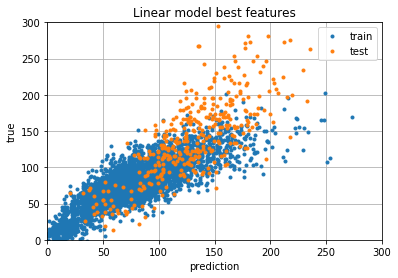

In [471]:
plt.figure()
plt.plot(target_train,prediction_train,'.',label='train')
plt.plot(prediction_test,target_test,'.',label='test')
plt.xlim([0,300])
plt.ylim([0,300])
plt.xlabel('prediction')
plt.ylabel('true')
plt.title('Linear model best features')
plt.legend()
plt.grid(True)

In [472]:
best_number_lag = 3
best_window_size = 10

df_train_features = make_features(df_train_valid, 'num_orders', best_number_lag, best_window_size)
df_train_features = df_train_features.dropna()
name_features = df_train_features.columns.drop(['num_orders'])
features_train = df_train_features[name_features]
target_train = df_train_features['num_orders']

df_train_valid, df_test = train_test_split(df, shuffle=False, test_size=0.1)

# define features and target of test dataset
df_test_features = make_features(df_test, 'num_orders', best_number_lag, best_window_size)
df_test_features = df_test_features.dropna()
name_features = df_test_features.columns.drop(['num_orders'])
features_test = df_test_features[name_features]
target_test = df_test_features['num_orders']

lr = LinearRegression()
lr.fit(features_train, target_train)
prediction_test = lr.predict(features_test)
rmse_test = mean_squared_error (target_test, prediction_test) ** 0.5
print("RMSE for linear model (test) : {:.1f}".format(rmse_test))
print("Number of features : {:}".format(features_test.shape[1]))

RMSE for linear model (test) : 47.1
Number of features : 11


In [473]:
prediction_train = lr.predict(features_train)

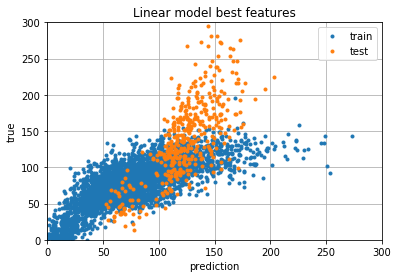

In [474]:
plt.figure()
plt.plot(target_train,prediction_train,'.',label='train')
plt.plot(prediction_test,target_test,'.',label='test')
plt.xlim([0,300])
plt.ylim([0,300])
plt.xlabel('prediction')
plt.ylabel('true')
plt.title('Linear model best features')
plt.legend()
plt.grid(True)

## 2.2.2 random forest

In [482]:
def rf_cross_validation_time_series(df_train_valid, valid_size, num_blocks,
                                    max_lag, rolling_mean_size, 
                                    max_depth, n_estimators, num_digits):
    
    #save result to list
    rmse_valid_list = []
    # from the biggest to the smallest
    size_cut_valid = 0 # how much to cut from the end
    for k_block in range(num_blocks):
        
        # split data on train and validation datasets 
        length_df = df_train_valid.shape[0]
        df_train, df_valid = train_test_split(df_train_valid[:(length_df - size_cut_valid)],
                                              shuffle=False,
                                              test_size=valid_size)
        
        # make features and dropna
        df_train_features = make_features(df_train, 'num_orders', max_lag, rolling_mean_size)
        df_valid_features = make_features(df_valid, 'num_orders', max_lag, rolling_mean_size)
        df_train_features = df_train_features.dropna()
        df_valid_features = df_valid_features.dropna()
        
        # determine features and targets
        name_features = df_train_features.columns.drop(['num_orders'])
        features_train = df_train_features[name_features]
        target_train = df_train_features['num_orders']

        features_valid = df_valid_features[name_features]
        target_valid = df_valid_features['num_orders']
        
        # training
        rf = RandomForestRegressor(random_state=0,
                                  n_estimators=n_estimators,
                                  max_depth=max_depth)
        rf.fit(features_train, target_train)
        
        # prediction + metrics + save result
        prediction_valid = rf.predict(features_valid)
        rmse_valid = mean_squared_error (target_valid, prediction_valid) ** 0.5
        rmse_valid_list.append(rmse_valid)
        
        # each time we cut from the initial dataframe, so size of cutting increase
        size_cut_valid += df_valid.shape[0]
    
    # return mean value
    return round(sum(rmse_valid_list) / len(rmse_valid_list), num_digits)


# application example
valid_size = 0.1
num_blocks = 3
max_lag = 3
rolling_mean_size = 12
num_digits = 2
max_depth = 10
n_estimators = 100
rf_cross_validation_time_series(df_train_valid, valid_size, num_blocks, 
                                max_lag,rolling_mean_size, 
                                max_depth, n_estimators,
                                num_digits)

28.01

In [483]:
# tune parameters: max_lag, rolling_mean_size, max_depth, n_estimators

result_random_forest = []
for number_lag in range(1,100,40):
    for window_size in range(1,50,20):
        for k_max_depth in range(9,11,1):
            for k_estimators in range(100,300,100):        
        
                valid_size = 0.1
                num_blocks = 3
                max_lag = number_lag
                rolling_mean_size = window_size
                num_digits = 2
                max_depth = k_max_depth
                n_estimators = k_estimators

                result_cross_validation = rf_cross_validation_time_series(
                                        df_train_valid, valid_size, num_blocks, 
                                        max_lag,rolling_mean_size, 
                                        max_depth, n_estimators,
                                        num_digits)
                result_random_forest.append([number_lag, window_size, 
                                             k_max_depth, k_estimators,
                                             result_cross_validation])

In [488]:
columns_rf_results = ['number_lag', 'window_size', 'max_depth', 'n_estimators', 'rmse_rf_validation']
df_result_random_forest = pd.DataFrame(result_random_forest, columns=columns_rf_results).sort_values('rmse_rf_validation')

In [489]:
df_result_random_forest

,number_lag,window_size,max_depth,n_estimators,rmse_rf_validation
31,81,21,10,200,27.82
30,81,21,10,100,27.86
26,81,1,10,100,27.91
29,81,21,9,200,27.93
28,81,21,9,100,27.94
27,81,1,10,200,27.96
19,41,21,10,200,27.96
35,81,41,10,200,28.00
34,81,41,10,100,28.01
23,41,41,10,200,28.03


In [487]:
best_number_lag = df_result_random_forest[0:1]['number_lag'].values[0]
best_window_size = df_result_random_forest[0:1]['window_size'].values[0]
best_max_depth = df_result_random_forest[0:1]['max_depth'].values[0]
best_n_estimators = df_result_random_forest[0:1]['n_estimators'].values[0]

In [490]:
# determine train dataset with the best parameters
df_train_features = make_features(df_train_valid, 'num_orders', best_number_lag, best_window_size)
df_train_features = df_train_features.dropna()
name_features = df_train_features.columns.drop(['num_orders'])
features_train = df_train_features[name_features]
target_train = df_train_features['num_orders']

In [491]:
# again recover test dataset
df_train_valid, df_test = train_test_split(df, shuffle=False, test_size=0.1)

# define features and target of test dataset
df_test_features = make_features(df_test, 'num_orders', best_number_lag, best_window_size)
df_test_features = df_test_features.dropna()
name_features = df_test_features.columns.drop(['num_orders'])
features_test = df_test_features[name_features]
target_test = df_test_features['num_orders']

rf = RandomForestRegressor(random_state=0,
                          n_estimators=best_n_estimators,
                          max_depth=best_max_depth)
rf.fit(features_train, target_train)
prediction_test = rf.predict(features_test)
rmse_test = mean_squared_error (target_test, prediction_test) ** 0.5
print("RMSE for random forest model (test) : {:.1f}".format(rmse_test))

RMSE for random forest model (test) : 41.6


In [492]:
print("Number of features : {:}".format(features_test.shape[1]))


Number of features : 89


In [493]:
prediction_train = rf.predict(features_train)

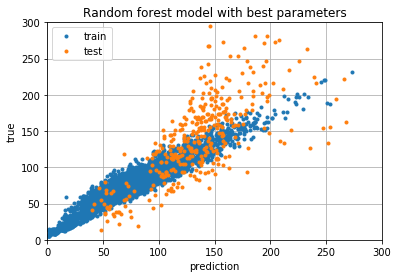

In [494]:
plt.figure()
plt.plot(target_train,prediction_train,'.',label='train')
plt.plot(prediction_test,target_test,'.',label='test')
plt.xlim([0,300])
plt.ylim([0,300])
plt.xlabel('prediction')
plt.ylabel('true')
plt.title('Random forest model with best parameters')
plt.legend()
plt.grid(True)

In [495]:
# try random forest model

# create new features
df_new = make_features(df, 'num_orders', 200, 30)

#drop N/A values
df_new = df_new.dropna()

train, test = train_test_split(df_new, shuffle=False, test_size=0.1)

name_features = df_new.columns.drop(['num_orders'])
features_train = train[name_features]
target_train = train['num_orders']

features_test = test[name_features]
target_test = test['num_orders']

rf = RandomForestRegressor(random_state=0)
rf.fit(features_train, target_train)
prediction_test = rf.predict(features_test)
prediction_train = rf.predict(features_train)

rmse_test = mean_squared_error (target_test, prediction_test, squared=False)
rmse_train = mean_squared_error (target_train, prediction_train, squared=False)

print("RMSE for random forest model (train): {:.1f}".format(rmse_train))
print("RMSE for random forest model (test) : {:.1f}".format(rmse_test))

RMSE for linear model (train): 8.0
RMSE for linear model (test) : 39.6


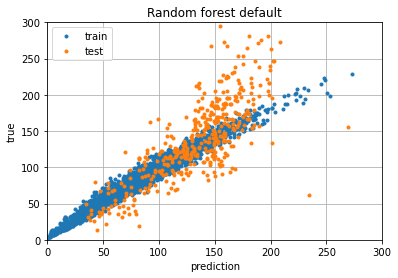

In [497]:
plt.figure()
plt.plot(target_train,prediction_train,'.',label='train')
plt.plot(prediction_test,target_test,'.',label='test')
plt.xlim([0,300])
plt.ylim([0,300])
plt.xlabel('prediction')
plt.ylabel('true')
plt.title('Random forest default')
plt.legend()
plt.grid(True)

**Note...:**
Random forest gives worse results, but it still very good (<40). <br>
RMSE for random forest model (train): 8.0 <br>
RMSE for random forest model (test) : 39.6

In [498]:
# tune random forest model

# create new features
df_new = make_features(df, 'num_orders', 200, 30)

#drop N/A values
df_new = df_new.dropna()

train, test = train_test_split(df_new, shuffle=False, test_size=0.1)

name_features = df_new.columns.drop(['num_orders'])
features_train = train[name_features]
target_train = train['num_orders']

features_test = test[name_features]
target_test = test['num_orders']

result_rf = []
for kmax_depth in range(9,11):
    for kn_estimators in range(300, 500,100):
        rf = RandomForestRegressor(max_depth=kmax_depth,
                                   n_estimators=kn_estimators,
                                   random_state=0
                                    )
        rf.fit(features_train, target_train)
        prediction_test = rf.predict(features_test)
        prediction_train = rf.predict(features_train)

        rmse_test = mean_squared_error (target_test, prediction_test, squared=False)
        rmse_train = mean_squared_error (target_train, prediction_train, squared=False)
        
        result_rf.append([kmax_depth, kn_estimators, rmse_train, rmse_test])

In [499]:
result_rf

[[9, 300, 13.362446607896228, 39.22434985141866],
 [9, 400, 13.358718765171231, 39.25284870641729],
 [10, 300, 11.945394940379126, 39.21477256377703],
 [10, 400, 11.933231970745252, 39.13313736656244]]

**So...:**
So, the best result is for default parameters
RMSE for random forest model (train): 8.0 <br>
RMSE for random forest model (test) : 39.6

## 2.2.3 catboost

In [495]:
def cat_cross_validation_time_series(df_train_valid, valid_size, num_blocks,
                                    max_lag, rolling_mean_size, 
                                    max_depth, n_estimators, num_digits):
    
    #save result to list
    rmse_valid_list = []
    # from the biggest to the smallest
    size_cut_valid = 0 # how much to cut from the end
    for k_block in range(num_blocks):
        
        # split data on train and validation datasets 
        length_df = df_train_valid.shape[0]
        df_train, df_valid = train_test_split(df_train_valid[:(length_df - size_cut_valid)],
                                              shuffle=False,
                                              test_size=valid_size)
        
        # make features and dropna
        df_train_features = make_features(df_train, 'num_orders', max_lag, rolling_mean_size)
        df_valid_features = make_features(df_valid, 'num_orders', max_lag, rolling_mean_size)
        df_train_features = df_train_features.dropna()
        df_valid_features = df_valid_features.dropna()
        
        # determine features and targets
        name_features = df_train_features.columns.drop(['num_orders'])
        features_train = df_train_features[name_features]
        target_train = df_train_features['num_orders']

        features_valid = df_valid_features[name_features]
        target_valid = df_valid_features['num_orders']
        
        # training
        cat = CatBoostRegressor(random_state=0,
                                  n_estimators=n_estimators,
                                  max_depth=max_depth)
        cat.fit(features_train, target_train)
        
        # prediction + metrics + save result
        prediction_valid = cat.predict(features_valid)
        rmse_valid = mean_squared_error (target_valid, prediction_valid) ** 0.5
        rmse_valid_list.append(rmse_valid)
        
        # each time we cut from the initial dataframe, so size of cutting increase
        size_cut_valid += df_valid.shape[0]
    
    # return mean value
    return round(sum(rmse_valid_list) / len(rmse_valid_list), num_digits)


# application example
valid_size = 0.1
num_blocks = 3
max_lag = 3
rolling_mean_size = 12
num_digits = 2
max_depth = 10
n_estimators = 100
cat_cross_validation_time_series(df_train_valid, valid_size, num_blocks, 
                                max_lag,rolling_mean_size, 
                                max_depth, n_estimators,
                                num_digits)

0:	learn: 35.4223446	total: 55.5ms	remaining: 5.49s
1:	learn: 34.8889584	total: 102ms	remaining: 4.98s
2:	learn: 34.4036184	total: 110ms	remaining: 3.55s
3:	learn: 33.8970564	total: 113ms	remaining: 2.71s
4:	learn: 33.4760431	total: 114ms	remaining: 2.17s
5:	learn: 33.0073318	total: 204ms	remaining: 3.2s
6:	learn: 32.5740343	total: 213ms	remaining: 2.82s
7:	learn: 32.1122854	total: 304ms	remaining: 3.5s
8:	learn: 31.7402071	total: 308ms	remaining: 3.12s
9:	learn: 31.3686517	total: 312ms	remaining: 2.81s
10:	learn: 30.9853521	total: 422ms	remaining: 3.41s
11:	learn: 30.6426241	total: 432ms	remaining: 3.17s
12:	learn: 30.3038824	total: 493ms	remaining: 3.3s
13:	learn: 29.9379526	total: 502ms	remaining: 3.08s
14:	learn: 29.5756528	total: 594ms	remaining: 3.37s
15:	learn: 29.2479589	total: 600ms	remaining: 3.15s
16:	learn: 28.9136998	total: 608ms	remaining: 2.97s
17:	learn: 28.5889999	total: 695ms	remaining: 3.17s
18:	learn: 28.2732519	total: 706ms	remaining: 3.01s
19:	learn: 27.9834160	to

30.44

In [496]:
# tune parameters: max_lag, rolling_mean_size, max_depth, n_estimators

result_cat_boost = []
for number_lag in range(1,100,50):
    for window_size in range(1,50,30):
        for k_max_depth in range(9,11,1):
            for k_estimators in range(100,300,100):        
        
                valid_size = 0.1
                num_blocks = 3
                max_lag = number_lag
                rolling_mean_size = window_size
                num_digits = 2
                max_depth = k_max_depth
                n_estimators = k_estimators

                result_cross_validation = cat_cross_validation_time_series(
                                        df_train_valid, valid_size, num_blocks, 
                                        max_lag,rolling_mean_size, 
                                        max_depth, n_estimators,
                                        num_digits)
                result_cat_boost.append([number_lag, window_size, 
                                             k_max_depth, k_estimators,
                                             result_cross_validation])

0:	learn: 35.4441284	total: 3.66ms	remaining: 362ms
1:	learn: 34.9238558	total: 8.27ms	remaining: 405ms
2:	learn: 34.4478489	total: 9.63ms	remaining: 311ms
3:	learn: 34.0116386	total: 11.1ms	remaining: 267ms
4:	learn: 33.5343328	total: 50ms	remaining: 951ms
5:	learn: 33.0594811	total: 53.7ms	remaining: 842ms
6:	learn: 32.6335490	total: 57.3ms	remaining: 761ms
7:	learn: 32.2145851	total: 66.2ms	remaining: 762ms
8:	learn: 31.8028051	total: 148ms	remaining: 1.5s
9:	learn: 31.4364557	total: 150ms	remaining: 1.35s
10:	learn: 31.0550958	total: 152ms	remaining: 1.23s
11:	learn: 30.6909449	total: 156ms	remaining: 1.14s
12:	learn: 30.3266173	total: 249ms	remaining: 1.67s
13:	learn: 29.9851887	total: 252ms	remaining: 1.55s
14:	learn: 29.6634474	total: 254ms	remaining: 1.44s
15:	learn: 29.3400706	total: 258ms	remaining: 1.35s
16:	learn: 29.0383336	total: 343ms	remaining: 1.67s
17:	learn: 28.7378045	total: 347ms	remaining: 1.58s
18:	learn: 28.4634521	total: 350ms	remaining: 1.49s
19:	learn: 28.212

In [498]:
columns_cat_results = ['number_lag', 'window_size', 'max_depth', 'n_estimators', 'rmse_cat_validation']
df_result_cat_boost = pd.DataFrame(result_cat_boost, columns=columns_cat_results).sort_values('rmse_cat_validation')

In [499]:
df_result_cat_boost

,number_lag,window_size,max_depth,n_estimators,rmse_cat_validation
13,51,31,9,200,28.15
9,51,1,9,200,28.23
15,51,31,10,200,28.50
11,51,1,10,200,28.69
5,1,31,9,200,29.32
7,1,31,10,200,29.63
12,51,31,9,100,29.87
1,1,1,9,200,29.94
8,51,1,9,100,30.02
3,1,1,10,200,30.16


In [500]:
best_number_lag = df_result_cat_boost[0:1]['number_lag'].values[0]
best_window_size = df_result_cat_boost[0:1]['window_size'].values[0]
best_max_depth = df_result_cat_boost[0:1]['max_depth'].values[0]
best_n_estimators = df_result_cat_boost[0:1]['n_estimators'].values[0]

In [501]:
# determine train dataset with the best parameters
df_train_features = make_features(df_train_valid, 'num_orders', best_number_lag, best_window_size)
df_train_features = df_train_features.dropna()
name_features = df_train_features.columns.drop(['num_orders'])
features_train = df_train_features[name_features]
target_train = df_train_features['num_orders']

In [506]:
# again recover test dataset
df_train_valid, df_test = train_test_split(df, shuffle=False, test_size=0.1)

# define features and target of test dataset
df_test_features = make_features(df_test, 'num_orders', best_number_lag, best_window_size)
df_test_features = df_test_features.dropna()
name_features = df_test_features.columns.drop(['num_orders'])
features_test = df_test_features[name_features]
target_test = df_test_features['num_orders']

cat = CatBoostRegressor(random_state=0,
                          n_estimators=n_estimators,
                          max_depth=max_depth)
cat.fit(features_train, target_train)
prediction_test = cat.predict(features_test)
rmse_test = mean_squared_error (target_test, prediction_test) ** 0.5
print("RMSE for cat boost model (test) : {:.1f}".format(rmse_test))

0:	learn: 38.0725980	total: 253ms	remaining: 50.4s
1:	learn: 37.4740583	total: 552ms	remaining: 54.7s
2:	learn: 36.9256453	total: 851ms	remaining: 55.9s
3:	learn: 36.3706280	total: 1.15s	remaining: 56.3s
4:	learn: 35.8629595	total: 1.45s	remaining: 56.6s
5:	learn: 35.3621034	total: 1.75s	remaining: 56.6s
6:	learn: 34.8720203	total: 2.06s	remaining: 56.7s
7:	learn: 34.3724038	total: 2.44s	remaining: 58.7s
8:	learn: 33.9129692	total: 2.75s	remaining: 58.3s
9:	learn: 33.4721186	total: 3.05s	remaining: 58s
10:	learn: 33.0005445	total: 3.44s	remaining: 59.2s
11:	learn: 32.5804994	total: 3.74s	remaining: 58.6s
12:	learn: 32.1717905	total: 4.04s	remaining: 58.2s
13:	learn: 31.7537618	total: 4.34s	remaining: 57.7s
14:	learn: 31.3687987	total: 4.65s	remaining: 57.3s
15:	learn: 31.0000003	total: 4.95s	remaining: 56.9s
16:	learn: 30.6387141	total: 5.25s	remaining: 56.5s
17:	learn: 30.2937715	total: 5.64s	remaining: 57s
18:	learn: 29.9432161	total: 5.93s	remaining: 56.5s
19:	learn: 29.6248596	tota

In [507]:
print("Number of features : {:}".format(features_test.shape[1]))


Number of features : 59


In [508]:
prediction_train = cat.predict(features_train)

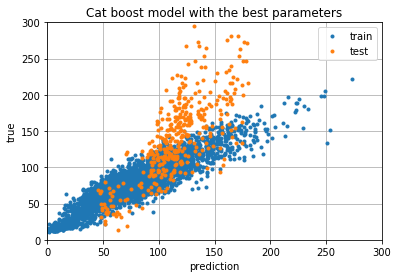

In [509]:
plt.figure()
plt.plot(target_train,prediction_train,'.',label='train')
plt.plot(prediction_test,target_test,'.',label='test')
plt.xlim([0,300])
plt.ylim([0,300])
plt.xlabel('prediction')
plt.ylabel('true')
plt.title('Cat boost model with the best parameters')
plt.legend()
plt.grid(True)

<div class="alert alert-info">
    <b> So...</b> <br>
    rmse with this best parameters is 49.8 > 48.0 <br>
    Check below default parameters (we know that they better). So we can check it on cross-validation and than apply it to test dataset.
</div>

In [510]:
# check default parameters...

# again recover test dataset
df_train_valid, df_test = train_test_split(df, shuffle=False, test_size=0.1)

# define features and target of test dataset
df_test_features = make_features(df_test, 'num_orders', best_number_lag, best_window_size)
df_test_features = df_test_features.dropna()
name_features = df_test_features.columns.drop(['num_orders'])
features_test = df_test_features[name_features]
target_test = df_test_features['num_orders']

cat = CatBoostRegressor(random_state=0)
cat.fit(features_train, target_train)
prediction_test = cat.predict(features_test)
rmse_test = mean_squared_error (target_test, prediction_test) ** 0.5
print("RMSE for cat boost model (test) : {:.1f}".format(rmse_test))

0:	learn: 38.0920952	total: 7.86ms	remaining: 7.86s
1:	learn: 37.5607490	total: 13ms	remaining: 6.5s
2:	learn: 37.0555535	total: 88ms	remaining: 29.3s
3:	learn: 36.5391688	total: 93.3ms	remaining: 23.2s
4:	learn: 36.0441806	total: 186ms	remaining: 37.1s
5:	learn: 35.5233337	total: 192ms	remaining: 31.8s
6:	learn: 35.0353540	total: 288ms	remaining: 40.8s
7:	learn: 34.5260965	total: 293ms	remaining: 36.3s
8:	learn: 34.0736743	total: 384ms	remaining: 42.3s
9:	learn: 33.6535708	total: 389ms	remaining: 38.5s
10:	learn: 33.2574557	total: 483ms	remaining: 43.4s
11:	learn: 32.8525776	total: 492ms	remaining: 40.5s
12:	learn: 32.4541445	total: 582ms	remaining: 44.2s
13:	learn: 32.0832205	total: 587ms	remaining: 41.3s
14:	learn: 31.7221529	total: 680ms	remaining: 44.7s
15:	learn: 31.3729074	total: 685ms	remaining: 42.1s
16:	learn: 31.0299031	total: 778ms	remaining: 45s
17:	learn: 30.7236091	total: 784ms	remaining: 42.8s
18:	learn: 30.4169198	total: 876ms	remaining: 45.2s
19:	learn: 30.1224290	tot

In [511]:
# default cross

def cat_cross_validation_time_series_def(df_train_valid, valid_size, num_blocks,
                                    max_lag, rolling_mean_size, 
                                    max_depth, n_estimators, num_digits):
    
    #save result to list
    rmse_valid_list = []
    # from the biggest to the smallest
    size_cut_valid = 0 # how much to cut from the end
    for k_block in range(num_blocks):
        
        # split data on train and validation datasets 
        length_df = df_train_valid.shape[0]
        df_train, df_valid = train_test_split(df_train_valid[:(length_df - size_cut_valid)],
                                              shuffle=False,
                                              test_size=valid_size)
        
        # make features and dropna
        df_train_features = make_features(df_train, 'num_orders', max_lag, rolling_mean_size)
        df_valid_features = make_features(df_valid, 'num_orders', max_lag, rolling_mean_size)
        df_train_features = df_train_features.dropna()
        df_valid_features = df_valid_features.dropna()
        
        # determine features and targets
        name_features = df_train_features.columns.drop(['num_orders'])
        features_train = df_train_features[name_features]
        target_train = df_train_features['num_orders']

        features_valid = df_valid_features[name_features]
        target_valid = df_valid_features['num_orders']
        
        # training
        cat = CatBoostRegressor(random_state=0)
        cat.fit(features_train, target_train)
        
        # prediction + metrics + save result
        prediction_valid = cat.predict(features_valid)
        rmse_valid = mean_squared_error (target_valid, prediction_valid) ** 0.5
        rmse_valid_list.append(rmse_valid)
        
        # each time we cut from the initial dataframe, so size of cutting increase
        size_cut_valid += df_valid.shape[0]
    
    # return mean value
    return round(sum(rmse_valid_list) / len(rmse_valid_list), num_digits)


# application example
valid_size = 0.1
num_blocks = 3
max_lag = 3
rolling_mean_size = 12
num_digits = 2
max_depth = 10
n_estimators = 100
cat_cross_validation_time_series_def(df_train_valid, valid_size, num_blocks, 
                                max_lag,rolling_mean_size, 
                                max_depth, n_estimators,
                                num_digits)

0:	learn: 35.4437858	total: 2.15ms	remaining: 2.15s
1:	learn: 34.8783196	total: 5.27ms	remaining: 2.63s
2:	learn: 34.3804173	total: 7.4ms	remaining: 2.46s
3:	learn: 33.8937809	total: 10.4ms	remaining: 2.58s
4:	learn: 33.4262031	total: 35.8ms	remaining: 7.11s
5:	learn: 32.9766447	total: 37.5ms	remaining: 6.22s
6:	learn: 32.5673225	total: 39.4ms	remaining: 5.59s
7:	learn: 32.1589119	total: 41.2ms	remaining: 5.11s
8:	learn: 31.8079632	total: 42.5ms	remaining: 4.68s
9:	learn: 31.4254521	total: 44.4ms	remaining: 4.39s
10:	learn: 31.0822393	total: 133ms	remaining: 12s
11:	learn: 30.7300375	total: 135ms	remaining: 11.2s
12:	learn: 30.3788143	total: 137ms	remaining: 10.4s
13:	learn: 30.0338028	total: 139ms	remaining: 9.79s
14:	learn: 29.7116648	total: 142ms	remaining: 9.29s
15:	learn: 29.4190213	total: 144ms	remaining: 8.83s
16:	learn: 29.1240384	total: 233ms	remaining: 13.5s
17:	learn: 28.8483069	total: 235ms	remaining: 12.8s
18:	learn: 28.5957120	total: 237ms	remaining: 12.2s
19:	learn: 28.3

27.31

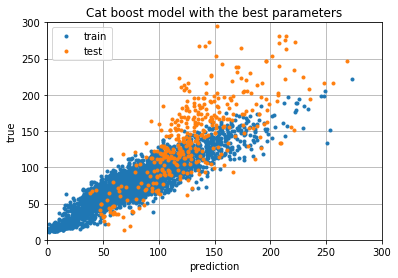

In [512]:
plt.figure()
plt.plot(target_train,prediction_train,'.',label='train')
plt.plot(prediction_test,target_test,'.',label='test')
plt.xlim([0,300])
plt.ylim([0,300])
plt.xlabel('prediction')
plt.ylabel('true')
plt.title('Cat boost model with the best parameters')
plt.legend()
plt.grid(True)

# Results

<div class="alert alert-info">
*Sanity check* <br>
RMSE for median prediction model: 87.2 <br>
RMSE for previous value model: 58.9 <br><br>
*Linear* number_lag=77 and window_size=26 <br>
RMSE for linear model (test) : 42.9 <br><br>
*Random forest* number_lag=81, window_size=21, max_depth=10, n_estimators=200 <br>
RMSE for random forest model (test) : 41.6 <br><br>
*Cat boost* max_lag = 3 rolling_mean_size = 12<br>
RMSE for cat boost model (test) : 40.9 <br>
</div>

<div class="alert alert-info">
**Conclusion**
The best model is a cat boost model with default parameters. <br>
It gives RMSE (test) : 40.9 which is better than neccessary value 48.0. <br>
</div>